# ML4Earth-Hackthon 2024 

In this notebook we present the results of training our Prithvi4QR model. All metrics are imported using the tensorboard logs.

If using relative paths is leading to an error, please adjust the **log_ft** variable with the absolute path of the **tensorboard log directory**. 

Like this you will be able to display multiple example images at the ned of this notebook. 

# Imports 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from tabulate import tabulate 
from tensorboard.backend.event_processing import event_accumulator

from PIL import Image
import io
import numpy as np

# Read tensorboard logs 

In [2]:
# Set paths to tb logs
log_ft = './logs/epoch_50'

ea_ft = event_accumulator.EventAccumulator(log_ft)
ea_ft.Reload()

In [3]:
def extract_metrics_to_dfs(ea, tags):
    dfs = {}
    ea.Reload()
    common_steps = [entry.step for entry in ea.Scalars(tags[0])]

    for tag in tags:
        scalar_data = ea.Scalars(tag)
        df = pd.DataFrame(scalar_data)
        df.columns = ['wall_time', 'step', tag]
        df = df[df['step'].isin(common_steps)].reset_index(drop=True)
        dfs[tag] = df[['step', tag]]

    # Merge DataFrames based on the 'step' column to synchronize epochs across tags
    merged_df = dfs[tags[0]]
    for tag in tags[1:]:
        merged_df = merged_df.merge(dfs[tag], on='step', how='inner')

    return merged_df

In [4]:
def plot_metrics_per_step(df, title, ylabel, line_styles=None, xlabel='Steps', ax=None):
    if ax is None:
        ax = plt.gca()  # Get current Axes if not provided
    
    for col in df.columns[1:]:
        ax.plot(df['step'], df[col], label=col, linestyle=line_styles[col] if line_styles else '-')
        
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Steps')
        ax.legend()

In [5]:
def extract_test_metrics_to_df(decimal=2):
    filter_tags = [
    'test/Multiclass_Accuracy',
    'test/Multiclass_F1_Score',
    'test/Multiclass_Jaccard_Index',
    'test/Multiclass_Jaccard_Index_Micro',
    'test/loss',
    'test/multiclassaccuracy_Background',
    'test/multiclassaccuracy_Building',
    'test/multiclassaccuracy_Road',
    'test/multiclassaccuracy_Water',
    'test/multiclassaccuracy_Woodland',
    'test/multiclassjaccardindex_Background',
    'test/multiclassjaccardindex_Building',
    'test/multiclassjaccardindex_Road',
    'test/multiclassjaccardindex_Water',
    'test/multiclassjaccardindex_Woodland',
    ]
    
    df = extract_metrics_to_dfs(ea_ft, filter_tags)

    df = df.drop(columns=['step'])
    column_names = [tag.split('/', 1)[1] for tag in filter_tags]
    df.columns = column_names

    df_melt = df.melt(var_name='Metric', value_name='Value')
    df_melt['Value'] = df_melt['Value'].round(decimal)

    return df_melt

# Define dataframes 

In [6]:
# Losses
filter_tags = [
    'train/loss',
    'val/loss'
]
df_losses = extract_metrics_to_dfs(ea_ft, filter_tags)
column_names = [tag.split('/')[0] for tag in filter_tags]
column_names.insert(0, 'step')
df_losses.columns = column_names

In [7]:
# Jaccard Index
filter_tags = [
    'val/Multiclass_Jaccard_Index',
    'val/multiclassjaccardindex_Background',
    'val/multiclassjaccardindex_Building',
    'val/multiclassjaccardindex_Woodland',
    'val/multiclassjaccardindex_Water',
    'val/multiclassjaccardindex_Road'
]

df_jaccard = extract_metrics_to_dfs(ea_ft, filter_tags)
column_names = [tag.split('_')[-1] if not tag == 0 else tag.split('/')[-1] for tag in filter_tags]
column_names.insert(0, 'step')

df_jaccard.columns = column_names

line_styles = ['-.', '--', '-', '-', '-', '-', '-']
line_styles_j = dict(zip(column_names[1:], line_styles))

In [8]:
# Accuracies
filter_tags = [
    'val/Multiclass_Accuracy',
    'val/multiclassaccuracy_Background',
    'val/multiclassaccuracy_Building',
    'val/multiclassaccuracy_Woodland',
    'val/multiclassaccuracy_Water',
    'val/multiclassaccuracy_Road',
]

df_acc = extract_metrics_to_dfs(ea_ft, filter_tags)
column_names = [tag.split('_')[-1] if not tag == 0 else tag.split('/')[-1] for tag in filter_tags]
column_names.insert(0, 'step')

df_acc.columns = column_names

line_styles = ['-.', '--', '-', '-', '-', '-', '-']
line_styles_acc = dict(zip(column_names[1:], line_styles))

# Charts and Metrics

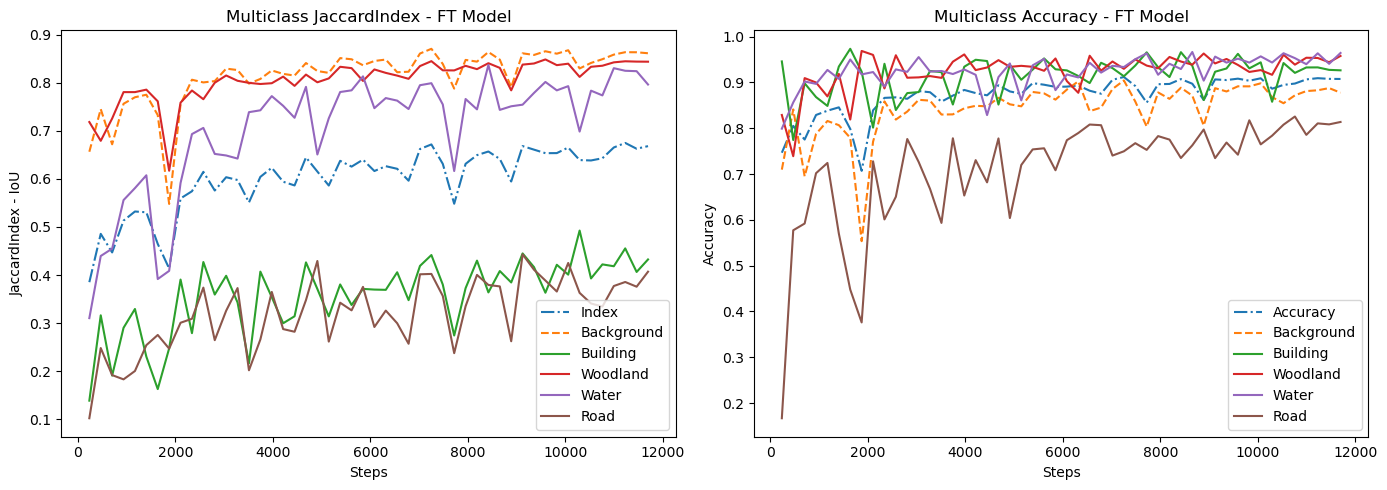

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

plot_metrics_per_step(df_jaccard,
                      ylabel='JaccardIndex - IoU',
                      title='Multiclass JaccardIndex - FT Model',
                      line_styles = line_styles_j,
                      ax=axs[0])

plot_metrics_per_step(df_acc,
                      ylabel='Accuracy',
                      title='Multiclass Accuracy - FT Model',
                      line_styles = line_styles_acc,
                      ax=axs[1])

plt.tight_layout()
plt.show()

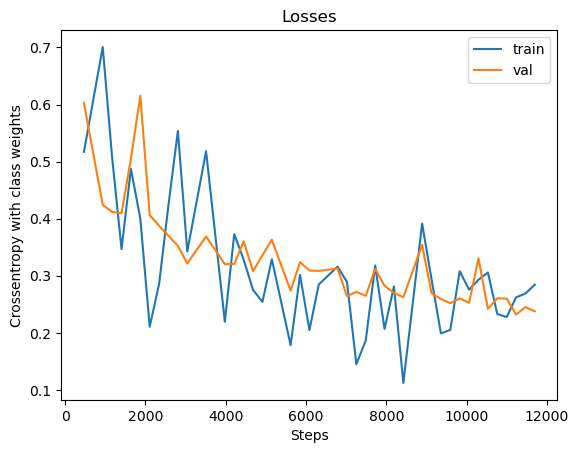

In [10]:
plot_metrics_per_step(df_losses,
                      ylabel='Crossentropy with class weights',
                      title='Losses')

In [11]:
test_metrics = extract_test_metrics_to_df(decimal=4)

In [12]:
print(tabulate(test_metrics, headers='keys', tablefmt='pretty'))

+----+-----------------------------------+--------+
|    |              Metric               | Value  |
+----+-----------------------------------+--------+
| 0  |        Multiclass_Accuracy        | 0.9043 |
| 1  |        Multiclass_F1_Score        | 0.9043 |
| 2  |     Multiclass_Jaccard_Index      | 0.6668 |
| 3  |  Multiclass_Jaccard_Index_Micro   | 0.8253 |
| 4  |               loss                | 0.2467 |
| 5  |   multiclassaccuracy_Background   | 0.8682 |
| 6  |    multiclassaccuracy_Building    | 0.9203 |
| 7  |      multiclassaccuracy_Road      | 0.7974 |
| 8  |     multiclassaccuracy_Water      | 0.9532 |
| 9  |    multiclassaccuracy_Woodland    | 0.9612 |
| 10 | multiclassjaccardindex_Background | 0.8502 |
| 11 |  multiclassjaccardindex_Building  | 0.4335 |
| 12 |    multiclassjaccardindex_Road    |  0.41  |
| 13 |   multiclassjaccardindex_Water    | 0.7885 |
| 14 |  multiclassjaccardindex_Woodland  | 0.8521 |
+----+-----------------------------------+--------+


# Display images 

In [13]:
def display_example_image(ea, index):
    image_tags = ea.Tags()['images']  
    selected_tag = image_tags[index]
    image_events = ea_ft.Images(selected_tag)
    
    for img_event in image_events:
        img_encoded = img_event.encoded_image_string  # This is a byte string
        img = Image.open(io.BytesIO(img_encoded))  # Decode the byte string using PIL
        
        plt.imshow(np.array(img))
        plt.title(f"Step: {img_event.step}, Tag: {selected_tag}")
        plt.axis('off')  
        plt.show()
    

If you cloned the repository you can have a look at the models training on 10 examples.

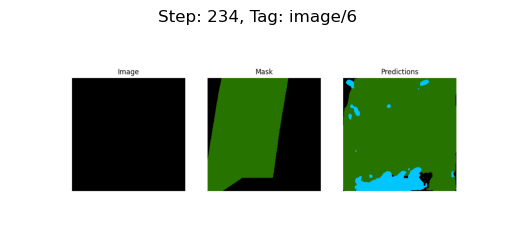

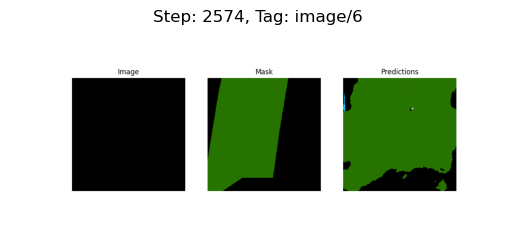

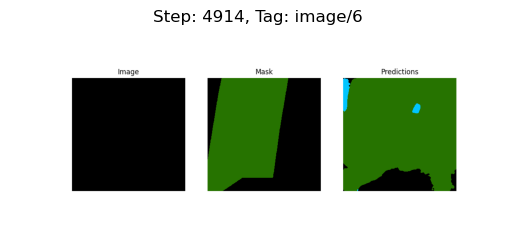

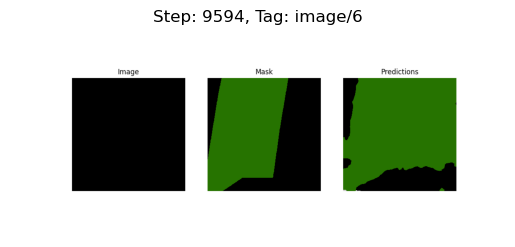

In [14]:
display_example_image(ea_ft, 6)